In [127]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import numpy as np

import jax
import jax.numpy as jnp
from jax.flatten_util import ravel_pytree

from nn import SIREN, fit
from utils import pool_image, get_coords_for_image

import matplotlib.pyplot as plt

## Step by Step process

### Load and process image

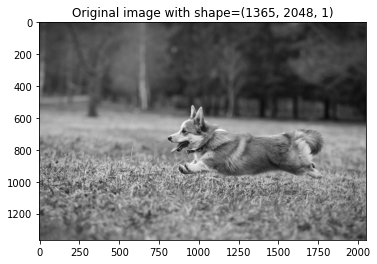

In [128]:
np_image = plt.imread("/home/patel_zeel/delhi_aq/data/images/dog_2.jpg")
np_image = np_image / 255.0
np_image = np_image.mean(axis=2, keepdims=True)
image = jnp.asarray(np_image)

plt.figure()
plt.imshow(np_image, cmap='gray');
plt.title(f"Original image with shape={image.shape}");

### Remove a few rows and columns

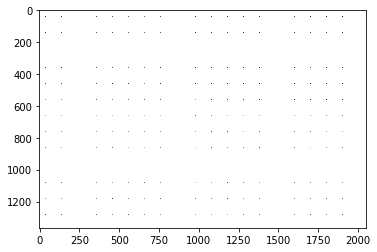

In [129]:
mask = jnp.zeros(image.shape, dtype=bool).at[::20, ::20, :].set(True)
masked_image = image.at[~mask].set(jnp.nan)

# interpolation_methods = [None, 'none', 'nearest', 'bilinear', 'bicubic', 'spline16',
#            'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric',
#            'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos', ""]

plt.imshow(masked_image, cmap='gray', interpolation='none');

### Prepare data for training

In [130]:
all_coords = get_coords_for_image(image, width_minmax=(-1, 1), heigh_minmax=(-1, 1))
print(f"{all_coords.shape=}, {image.shape=}")

train_coords = jax.vmap(lambda coords: coords[mask[:, :, 0]], in_axes=2, out_axes=1)(all_coords)
train_image = jax.vmap(lambda image: image[mask[:, :, 0]], in_axes=2, out_axes=1)(image)
print(f"{train_coords.shape=}, {train_image.shape=}, train % = {100*mask.sum() / mask.size}")

all_coords.shape=(1365, 2048, 2), image.shape=(1365, 2048, 1)
train_coords.shape=(7107, 2), train_image.shape=(7107, 1), train % = 0.2542282044887543


In [131]:
%%time
model = SIREN(n_hidden_layer_neurons=[256, 256, 256, 256], output_shape=train_image.shape[-1])
params, losses = fit(jax.random.PRNGKey(0), model, train_coords, train_image, lr=1e-3, batch_size=-1, iterations=1000)

CPU times: user 2.3 s, sys: 348 ms, total: 2.65 s
Wall time: 1.12 s


Array(1.8490767e-06, dtype=float32)

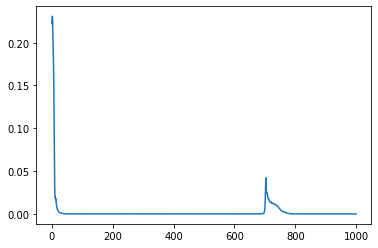

In [132]:
offset = 0
plt.plot(losses[offset:]);
losses[-1]

### Predict

In [133]:
np_pred_image = np.array(model.vapply(params, all_coords))
rmse = np.sqrt(np.mean((np_pred_image - np_image)**2))
print(f"RMSE = {rmse:.4f}")

RMSE = 0.0861


### Insights

In [134]:
diff = np_image - np_pred_image

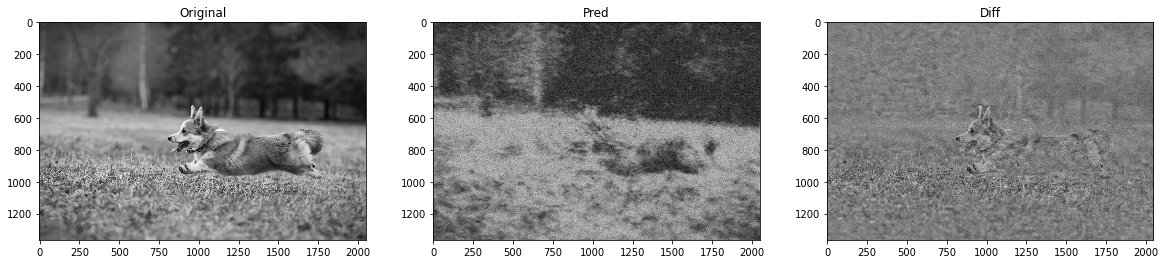

In [135]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
for img, title, ax in zip([np_image, np_pred_image, diff], ["Original", "Pred", "Diff"], axes):
    ax.imshow(img, cmap='gray', interpolation='none')
    ax.set_title(title)
    # ax.axis('off')

In [136]:
print("Max", jnp.abs(diff).max())
print("Min", jnp.abs(diff).min())
print("Mean", jnp.abs(diff).mean())

Max 0.7453723
Min 4.3865903e-08
Mean 0.06407395


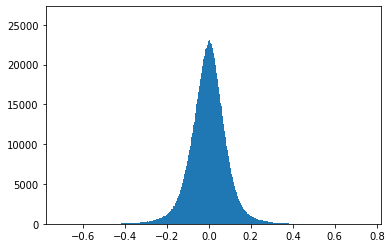

In [137]:
plt.hist(np.array(diff).ravel(), bins=1000, label='diff');

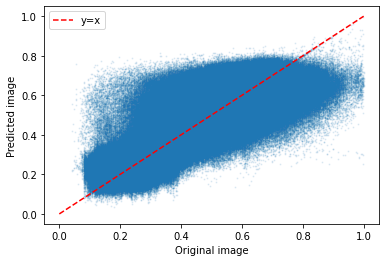

In [138]:
plt.scatter(np_image.ravel(), np_pred_image.ravel(), s=1, alpha=0.1);
plt.plot([0, 1], [0, 1], 'r--', label='y=x');
plt.legend();
plt.xlabel("Original image");
plt.ylabel("Predicted image");

## All in One

In [139]:
class Config:
    path = '/home/patel_zeel/delhi_aq/data/images/dog_2.jpg'
    grayscale = False
    reduce_size_by_factor = 1
    mask_gap = 2
    layers = [256, 256, 256, 256]
    lr = 1e-3
    batch_size = -1
    iterations = 1000
    key = jax.random.PRNGKey(42)
    
config = Config()

In [140]:
def run(config):
    np_image = plt.imread(config.path)
    np_image = np_image / 255.0
    np_image = np_image.mean(axis=2, keepdims=True)
    image = jnp.asarray(np_image)
    
    mask = jnp.zeros(image.shape, dtype=bool).at[::config.mask_gap, ::config.mask_gap, :].set(True)
    percentage = 100*mask.sum() / mask.size

    all_coords = get_coords_for_image(image, width_minmax=(-1, 1), heigh_minmax=(-1, 1))
    train_coords = jax.vmap(lambda coords: coords[mask[:, :, 0]], in_axes=2, out_axes=1)(all_coords)
    train_image = jax.vmap(lambda image: image[mask[:, :, 0]], in_axes=2, out_axes=1)(image)
    
    model = SIREN(n_hidden_layer_neurons=config.layers, output_shape=train_image.shape[-1])
    params, losses = fit(config.key, model, train_coords, train_image, lr=config.lr, batch_size=config.batch_size, iterations=config.iterations)
    
    np_pred_image = np.array(model.vapply(params, all_coords))
    
    rmse = np.sqrt(np.mean((np_image - np_pred_image)**2))

    return percentage, rmse, np_pred_image

In [141]:
gaps = [3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30]
percentages = []
rmses = []
pred_images = []
for mask_gap in gaps:
    print(mask_gap)
    config = Config()
    config.mask_gap = mask_gap
    percentage, rmse, pred_image = run(config)
    percentages.append(percentage)
    pred_images.append(pred_image)
    rmses.append(rmse)
    print(f"{mask_gap=}, {percentage=:.2f}%, {rmse=:.4f}")

3
mask_gap=3, percentage=11.12%, rmse=0.0248
4
mask_gap=4, percentage=6.26%, rmse=0.0298
5
mask_gap=5, percentage=4.00%, rmse=0.0325
6
mask_gap=6, percentage=2.79%, rmse=0.0463
7
mask_gap=7, percentage=2.04%, rmse=0.0487
8
mask_gap=8, percentage=1.57%, rmse=0.0486
9
mask_gap=9, percentage=1.24%, rmse=0.0479
10
mask_gap=10, percentage=1.00%, rmse=0.0570
15
mask_gap=15, percentage=0.45%, rmse=0.0870
20
mask_gap=20, percentage=0.25%, rmse=0.1792
30
mask_gap=30, percentage=0.11%, rmse=0.1788


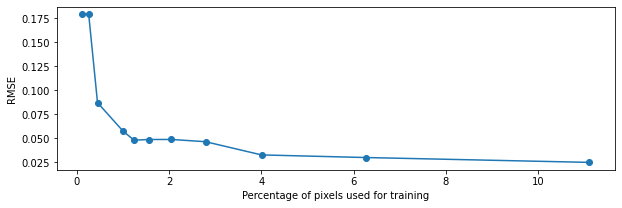

In [145]:
plt.figure(figsize=(10, 3))
plt.plot(percentages, rmses, 'o-')
# plt.xticks(percentages)
plt.xlabel("Percentage of pixels used for training")
plt.ylabel("RMSE");

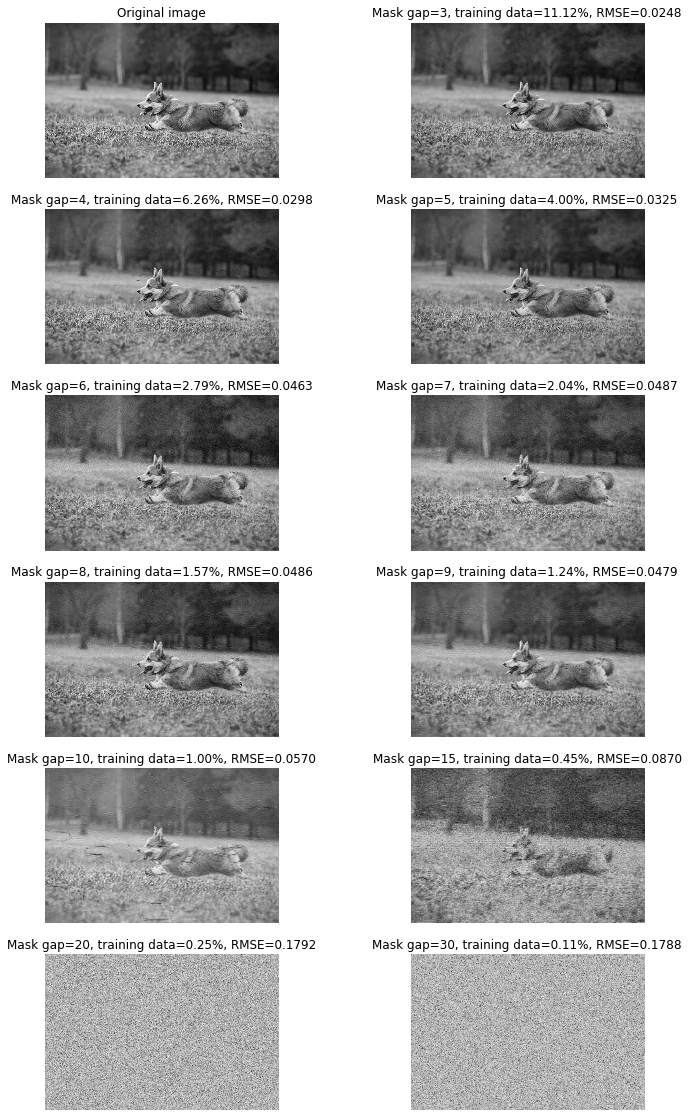

In [152]:
fig, axes = plt.subplots(6, 2, figsize=(12, 20))
axes = axes.ravel()

axes[0].imshow(np_image, cmap='gray', interpolation='none')
axes[0].set_title("Original image")

for i, (mask_gap, percentage, rmse, pred_image) in enumerate(zip(gaps, percentages, rmses, pred_images)):
    axes[i+1].imshow(pred_image, cmap='gray', interpolation='none')
    axes[i+1].set_title(f"Mask gap={mask_gap}, training data={percentage:.2f}%, RMSE={rmse:.4f}")
    
for ax in axes:
    ax.axis('off')

## Insights

* SIRENs work well even when training data is extremely sparse.
* Maybe after a sufficient number of pixels are given, rest pattern is predicted well by SIREN.
* Maybe in sparse training data regime, all we need is validation set to prevent overfitting.